In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import os
import shutil
from keras import layers, models, optimizers
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.


In [0]:
os.chdir('/content/drive/My Drive/open_ai/anime-classification')

In [0]:
data_dir = 'data'

train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)

Found 846 images belonging to 3 classes.
Found 213 images belonging to 3 classes.
Found 351 images belonging to 3 classes.


In [0]:
rev_class_indices = {value: key for key, value in train_generator.class_indices.items()}

In [0]:
for label_name in train_generator.class_indices:
  for directory in (train_dir, valid_dir, test_dir):
    label_dir = os.path.join(directory, label_name)
    print('Number of files in', label_dir, 'are', len( os.listdir(label_dir) ))

Number of files in data/train/goku are 300
Number of files in data/valid/goku are 75
Number of files in data/test/goku are 145
Number of files in data/train/luffy are 300
Number of files in data/valid/luffy are 75
Number of files in data/test/luffy are 207
Number of files in data/train/saitama are 300
Number of files in data/valid/saitama are 75
Number of files in data/test/saitama are 26


In [0]:
def visualize_dataset(data_generator, num_images, img_size=(40, 40)):
 
  filepaths = data_generator.filepaths
  
  rev_class_indices = {value: key for key, value in data_generator.class_indices.items()}
  labels = [rev_class_indices[label] for label in data_generator.labels]
  
  idx = np.random.choice(len(filepaths), size=num_images, replace=False)
  filepaths = [filepaths[i] for i in idx]
  labels = [labels[i] for i in idx]
    
  imgs = [ image.load_img(img_path, target_size=data_generator.target_size) \
          for img_path in filepaths ]
  
  fig = plt.figure(figsize=img_size)
  for i, img in enumerate(imgs):
    ax = fig.add_subplot(num_images, 1, i+1)
    ax.set_title(labels[i])
    plt.imshow(img)
  plt.show()
  plt.close(fig)

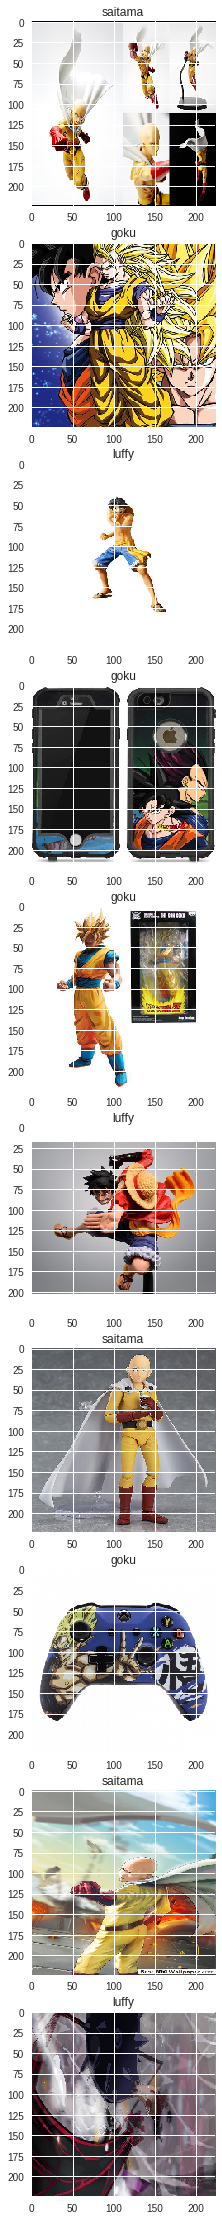

In [0]:
visualize_dataset(train_generator, 10, img_size=(40, 40))

In [0]:
model = models.Sequential()
model.add( layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)) )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(64, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(128, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(128, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(128, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Flatten() )
model.add( layers.Dense(256, activation='relu') )
model.add( layers.Dense(num_classes, activation='softmax') )

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv

In [0]:
model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer=optimizers.RMSprop(lr=1e-4)
)

In [0]:
models_dir = 'models'
model_filename = 'model5.h5'
model_filepath = os.path.join(models_dir, model_filename)

In [0]:
callbacks = [ EarlyStopping(monitor='val_acc', patience=10),
              ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True) ]

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=100,
    validation_data=valid_generator,
    validation_steps=10,
    callbacks=callbacks
)

In [0]:
model.save(model_filepath)

In [0]:
plot_loss_accuracy(history)

In [0]:
model.load_weights(model_filepath)

In [0]:
print(test_generator.n)
print(batch_size)
print(test_generator.n // batch_size)

In [0]:
model.evaluate_generator(test_generator, steps=test_generator.n//batch_size)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[0.7508371770381927, 0.7]

In [0]:
def visualize_model_on_test_data(model, data_generator, num_images, img_size=(20, 20)):
  filepaths = data_generator.filepaths
  
  rev_class_indices = {value: key for key, value in data_generator.class_indices.items()}
  labels = [rev_class_indices[label] for label in data_generator.labels]
  
  idx = np.random.choice(len(filepaths), size=num_images, replace=False)
  filepaths = [filepaths[i] for i in idx]
  labels = [labels[i] for i in idx]
    
  imgs = [ image.load_img(img_path, target_size=data_generator.target_size) \
          for img_path in filepaths ]
  
  imgs_array = [ image.img_to_array(img) for img in imgs ]
  imgs_array = [ img.reshape((1, ) + img.shape) for img in imgs_array ]
  preds = [ model.predict_classes(img)[0] for img in imgs_array ]
  probs = [ model.predict(img)[0][label] for img in imgs_array for img, label in zip(imgs_array, preds) ]
  
  rev_class_indices = {value: key for key, value in data_generator.class_indices.items()}
  preds = [ rev_class_indices[label] for label in preds ]
  
  for i, img in enumerate(imgs):
    plt.imshow(img)
    plt.title('Actual: ' + str(labels[i]) + ', Predicted: ' + str(preds[i]) + ', Probability: ' + str(probs[i]))
    plt.show()

In [0]:
visualize_model_on_test_data(model, test_generator, 50, img_size=(50, 50))

Output hidden; open in https://colab.research.google.com to view.